# Inferring Cosmo from PM Simulation

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# import jax; print(jax.__file__)
# !nvidia-smi

feynmangpu04.cluster.local


gpu [cuda(id=0)]


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples

import jax
from jax import random
import jax.numpy as jnp
import jax_cosmo as jc
# import astropy.units as u

import numpyro
# numpyro.set_platform("gpu")
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

# from jax.experimental.ode import odeint
# import haiku as hk

# import diffrax
# from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

## Probabilistic Model

In [3]:
from montecosmo.models import cosmo_prior, linear_pk_interp, linear_field
from jaxpm.pm import lpt
from jaxpm.painting import cic_paint

def forward_model(box_size, mesh_size, scale_factor_lpt, galaxy_density, trace_deterministic=False):
  """
  A forward model, where the relevant variables can be traced.
  """
  # Sample cosmology
  cosmology = cosmo_prior(trace_deterministic=True)

  # Sample initial conditions
  pk_fn = linear_pk_interp(cosmology, n_interp=256)
  init_mesh = linear_field(mesh_size, box_size, pk_fn)
  if trace_deterministic:
    init_mesh = numpyro.deterministic('init_mesh', init_mesh)

  # Create regular grid of particles
  particles_pos = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])
  
  # Initial displacement with LPT
  cosmology._workspace = {}  # FIXME: this a temporary fix
  dx, p, f = lpt(cosmology, init_mesh, particles_pos, a=scale_factor_lpt)
  # NOTE: lpt supposes given mesh follows linear pk at a=1, and correct by growth factor to get forces at wanted scale factor.
  particles_pos = particles_pos + dx

  # Cloud In Cell painting
  lpt_mesh = cic_paint(jnp.zeros(mesh_size), particles_pos)
  if trace_deterministic:
    lpt_mesh = numpyro.deterministic('lpt_mesh', lpt_mesh)

  # Observe
  ## Direct observation
  # lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Delta(lpt_mesh))
  ## Normal noise 
  # lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Normal(lpt_mesh, 0.1))
  ## Poisson noise
  gxy_intens_mesh = (lpt_mesh + 1) * (galaxy_density * box_size.prod() / mesh_size.prod())
  lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Poisson(gxy_intens_mesh))
  return lpt_mesh_obs

In [4]:
# Model params
model_kwargs = {}

## Mesh and box parameters
mesh_length = 32 # 64
box_length = 320 # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
model_kwargs['mesh_size'] = np.array([mesh_length, mesh_length, mesh_length])
model_kwargs['box_size'] = np.array([box_length, box_length, box_length])  # in Mpc/h

## Scale factor
model_kwargs['scale_factor_lpt'] = 0.1

## Galaxies
model_kwargs['galaxy_density'] = 1e-3 # in galaxy / (Mpc/h)^3

## Debugging
model_kwargs['trace_deterministic'] = True

cell_lengths=[10.0, 10.0, 10.0] Mpc/h
k_nyquist=0.31416 h/Mpc, delta_k=0.01963 h/Mpc
mean_galaxy_cell_intensity=1.000 galaxy/cell


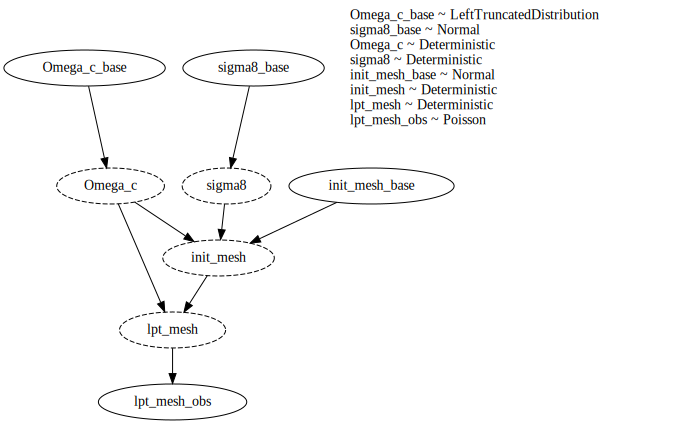

In [7]:
# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

## Simulate

In [8]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones

# Get trace
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)
# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
fiducial_cosmology = jc.Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


## Power spectra

In [7]:
from jaxpm.utils import power_spectrum
from montecosmo.utils import cic_compensate

# Get meshes from model trace
init_mesh, lpt_mesh = fiducial_model_trace['init_mesh']['value'], fiducial_model_trace['lpt_mesh']['value']

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
lpt_comp_mesh = cic_compensate(lpt_mesh) # compensate for CIC painting convolution
pk_lpt = power_spectrum(lpt_comp_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


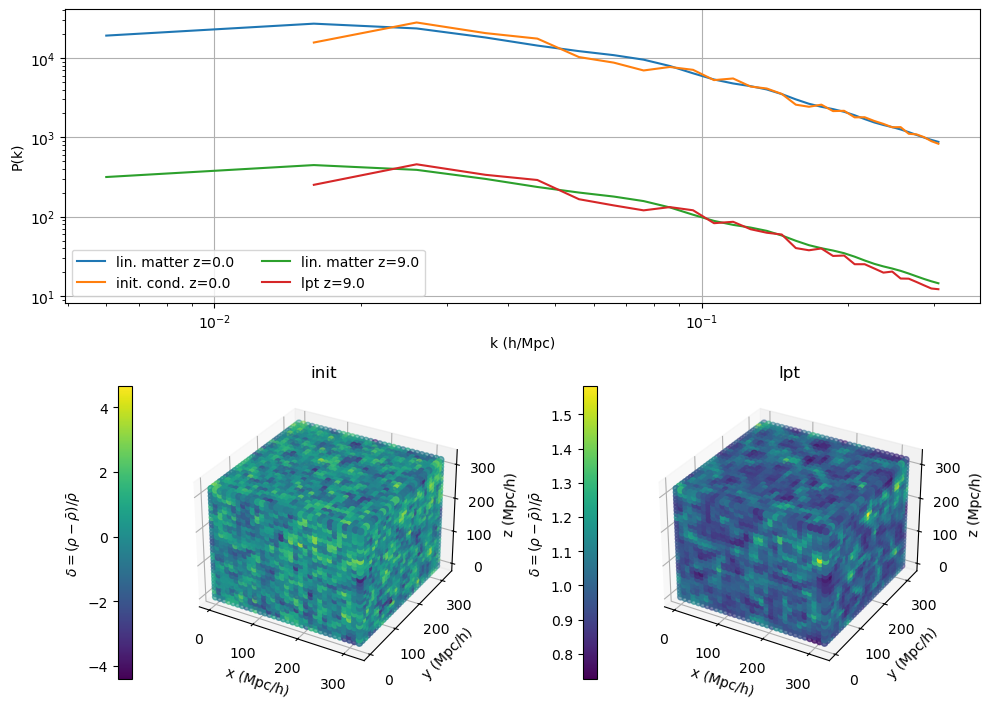

In [8]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"lin. matter z={1/1-1}")
plt.loglog(pk_init[0], pk_init[1], label=f"init. cond. z={1/1-1}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1}")
plt.loglog(pk_lpt[0], pk_lpt[1], label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1}")
plt.grid(), plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")

# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
init_color = init_mesh.flatten()
lpt_color = lpt_mesh.flatten()
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(223, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta = (\rho - \bar \rho) / {\bar \rho}$")
plt.title("init")

ax3D = plt.subplot(224, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta = (\rho - \bar \rho) / {\bar \rho}$")
plt.title("lpt")

plt.tight_layout(), plt.show();

## Inference

In [10]:
# Condition model
obs_var_names = ['lpt_mesh_obs'] # NOTE: Only condition on random sites
obs_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in obs_var_names}
observed_model = condition(forward_model, obs_values)  

# Initialize sampler
init_var_names = ['Omega_c_base', 'sigma8_base', 'init_mesh_base'] # NOTE: Only init on random sites
init_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in init_var_names}

nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    # init_strategy=partial(numpyro.infer.init_to_value, values=init_values),
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    max_tree_depth=5, # 3
    # inverse_mass_matrix=variance_as_invM, 
    # adapt_mass_matrix=False,
    # step_size=0.01, 
    # adapt_step_size=False
    )

mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=500,
       num_samples=1000, # for each run
    #    chain_method="vectorized", 
    #    num_chains=8,
       progress_bar=True
       )

In [ ]:
# Variables to save
save_var_names = cosmo_var_names + ['Omega_c_base', 'sigma8_base', 'init_mesh_base']
# Saves directory
save_directory = os.path.expanduser("~/scratch/npys/") # or in "~/work/npys/"
save_name = "obs_lpt__warmup_free__treedep_5"
save_name = save_name + "/" + save_name
# Number of runs
n_runs = 2

In [194]:
# Warmup sampling
if mcmc.num_warmup>=1:
    print(f"run {0}/{n_runs} (warmup)")
    key_warmup = random.PRNGKey(0)

    # Warmup
    mcmc.warmup(key_warmup, collect_warmup=True, **model_kwargs)
    warmup_samples = mcmc.get_samples()
    warmup_samples = {key: warmup_samples[key] for key in save_var_names}

    # Saving warmup
    save_path = os.path.join(save_directory, save_name+f"_{0}")
    np.save(save_path, warmup_samples)
    del warmup_samples

    # Handling rng key
    key_run = mcmc.post_warmup_state.rng_key
else:
    key_run = random.PRNGKey(0)

# Run sampling
for i_run in range(1, n_runs+1):
    print(f"run {i_run}/{n_runs}")
        
    # Run
    mcmc.run(key_run, **model_kwargs)
    run_samples = mcmc.get_samples()
    print(run_samples.keys())
    run_samples = {key: run_samples[key] for key in save_var_names}
    
    # Saving run
    save_path = os.path.join(save_directory, save_name+f"_{i_run}")
    np.save(save_path, run_samples)
    # del run_samples

    # Init next run at last state
    mcmc.post_warmup_state = mcmc.last_state
    key_run = mcmc.post_warmup_state.rng_key
# return mcmc

import pickle
save_path = os.path.join(save_directory, save_name+f"_laststate"+".p")
with open(save_path, 'wb') as file:
    pickle.dump(mcmc.last_state, file)
# with open('mypicklefile', 'rb') as f1:
#     truc = pickle.load(f1)

run 0/2 (warmup)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
  0%|          | 0/500 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getat

run 1/2


sample: 100%|██████████| 1000/1000 [03:57<00:00,  4.22it/s, 1 steps of size 5.72e-01. acc. prob=0.90]
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


dict_keys(['Omega_c', 'Omega_c_base', 'init_mesh', 'lpt_mesh', 'sigma8', 'sigma8_base'])
run 2/2


sample: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s, 3 steps of size 5.72e-01. acc. prob=0.90]


dict_keys(['Omega_c', 'Omega_c_base', 'init_mesh', 'lpt_mesh', 'sigma8', 'sigma8_base'])


## Analysis

In [ ]:
def load_and_append_runs(var_names, directory, file_name, start_run, end_run):
    """
    Load and append runs saved in different files with same name.
    """
    samples = {}
    for i_run in range(start_run, end_run+1):
        # Load
        load_path = os.path.join(directory, file_name+f"_{i_run}.npy")
        post_samples_part = np.load(load_path, allow_pickle=True).item()

        # Init or append samples
        if not samples:
            samples = {key: post_samples_part[key] for key in var_names}
        else:
            samples = {key: jnp.concatenate((samples[key], post_samples_part[key])) for key in var_names}
    print(f"total num samples={samples[var_names[0]].shape[0]}")
    return samples

# Load only cosmological samples
cosmo_post_samples = load_and_append_runs(cosmo_var_names, save_directory, save_name, start_run=0, end_run=2)
cosmo_post_samples_arr = np.array(list(cosmo_post_samples.values())).T
# Load saved samples
post_samples = load_and_append_runs(save_var_names, save_directory, save_name, start_run=0, end_run=2)
post_samples_arr = np.array(list(cosmo_post_samples.values())).T

FileNotFoundError: [Errno 2] No such file or directory: '/feynman/home/dphp/hs276503/scratch/npys/obs_lpt__warmup_free__treedep_5/obs_lpt__warmup_free__treedep_5_0.npy'

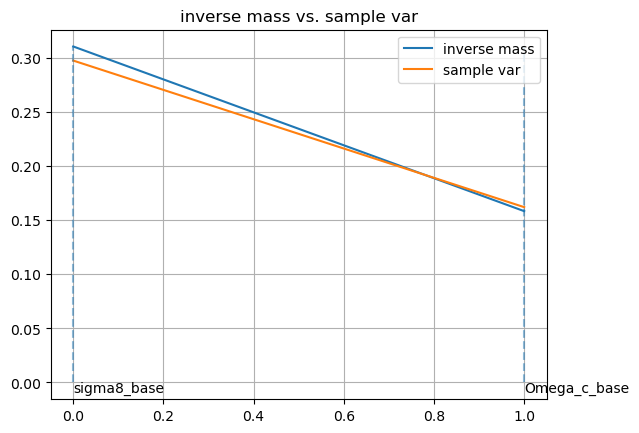

In [202]:
inverse_mass_matrix = mcmc.last_state.adapt_state.inverse_mass_matrix
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance = []
for var_name in var_names:
    post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))

argsort_invM = np.argsort(invM_arr) 
plt.plot(invM_arr[argsort_invM][::-1], label="inverse mass")
plt.plot(post_variance[argsort_invM][::-1], label="sample var")

argsort_argsort_invM = np.argsort(argsort_invM)
for i, s in enumerate(var_names):
    pos = len(invM_arr) - argsort_argsort_invM[[0,1]][i] - 1
    plt.text(pos, -0.03*np.max(invM_arr), s)
    plt.vlines(pos, 
           ymin=0, ymax=np.max(invM_arr), 
           ls="--", alpha=0.5,)
plt.legend(), plt.grid(), plt.title("inverse mass vs. sample var");

In [191]:
variance_as_invM = {var_names: post_variance}
print(variance_as_invM)
save_path = os.path.join(save_directory, save_name+"_invM")
np.save(save_path, run_samples)

{('Omega_c_base', 'sigma8_base'): array([0.15829644, 0.31043825])}


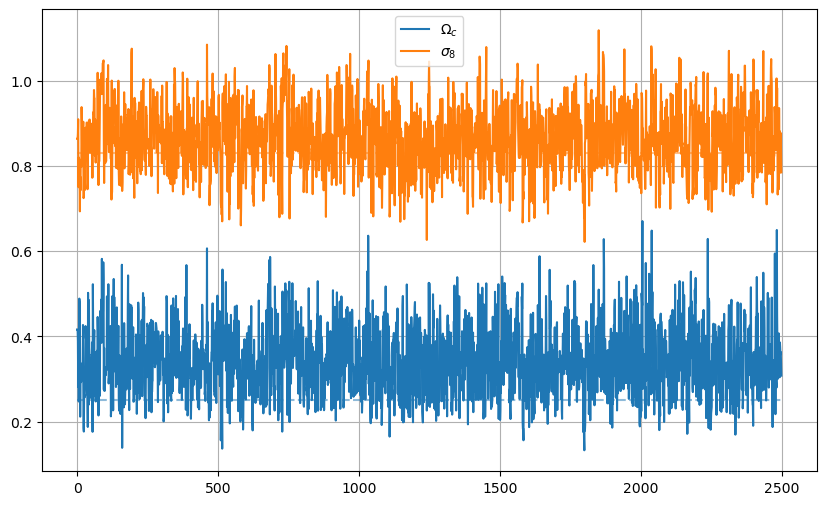

In [200]:
# Plot chain
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(cosmo_post_samples_arr, label=["$"+label+"$" for label in cosmo_var_labels])
plt.hlines(fiducial_cosmo_params.values(), 
           xmin=0, xmax=len(cosmo_post_samples_arr), 
           ls="--", alpha=0.5,
           color=["C"+str(i) for i in range(len(cosmo_post_samples_arr))],)
plt.legend(), plt.grid(), plt.show();

In [114]:
# Sample from prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size):
        cosmo_prior(trace_deterministic=True)

plate_size = 10000
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 0)).get_trace(plate_size)
cosmo_prior_samples_arr = np.array([cosmo_prior_trace[key]['value'] for key in cosmo_var_names]).T


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_c      0.34      0.08      0.34      0.22      0.48   1195.49      1.00
    sigma8      0.87      0.08      0.86      0.74      0.99    932.26      1.00

Removed no burn in
Removed no burn in


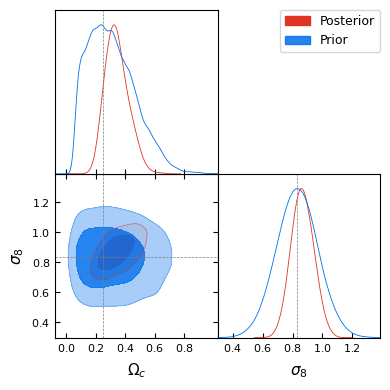

In [203]:
%matplotlib inline
# Diagnostics
numpyro.diagnostics.print_summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains

# Triangle plot
post_samples_gd = MCSamples(samples=cosmo_post_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
prior_samples_gd = MCSamples(samples=cosmo_prior_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
gd.triangle_plot(roots=[post_samples_gd, prior_samples_gd],
                 markers=fiducial_cosmo_params,
                 filled=True, 
                 legend_labels=["Posterior", "Prior"])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_c      0.34      0.08      0.33      0.21      0.47   1138.09      1.00
    sigma8      0.87      0.08      0.86      0.74      1.00   1016.58      1.00

Removed no burn in
Removed no burn in


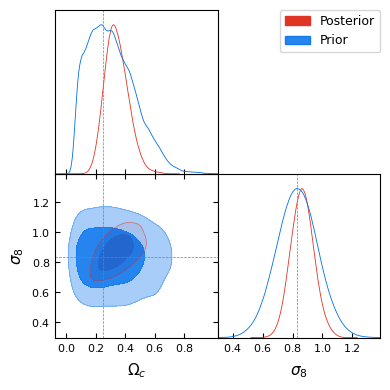

In [ ]:
%matplotlib inline
# Diagnostics
numpyro.diagnostics.print_summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains

# Triangle plot
post_samples_gd = MCSamples(samples=cosmo_post_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
prior_samples_gd = MCSamples(samples=cosmo_prior_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
gd.triangle_plot(roots=[post_samples_gd, prior_samples_gd],
                 markers=fiducial_cosmo_params,
                 filled=True, 
                 legend_labels=["Posterior", "Prior"])